# Fashion-MNIST Notebook
In this notebook we will try to classify different fashion items and clothes based on black-and-white pictures from the "fashion mnist" dataset without using neural networks.


Importing libraries and data:

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist #dataset

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() #dataset split
X_train.shape

(60000, 28, 28)

The dataset is an educational dataset, therefore the data is clean and useable (only simple scaling is required)

Example picture from the dataset:

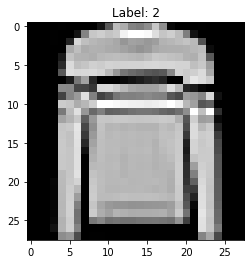

In [3]:
import matplotlib.pyplot as plt
example_img=X_train[5]
plt.imshow(example_img, cmap="gray")
plt.title('Label: '+str(y_train[5]))
plt.show()

## Labels legend:
0- T-shirt/top  
1- Trouser  
2- Pullover  
3- Dress  
4- Coat  
5- Sandal  
6- Shirt  
7- Sneaker  
8- Bag  
9- Ankle boot

The picture in the example (picture no. 5) represents a Pullover.

In [4]:
# test dataset size 
y_test.size

10000

Each picture has 28*28 pixels, 784 dimensions to the data.  
It's very hard to handle and not very effective because there are some pixels who are similar for all pictures (for example the pixels at the corners).

We will combat this problem in two ways, the first will be a limited decision tree.  
The tree will choose the most relevant dimensions to divide the data by.

The second solution will be dimensional reduction using PCA, with this method we will not only choose the most useful dimensions but also create new dimenstions that will represent combinations of multiple dimensions, compressing more data to the same number of dimensions.

## Data preparations

In [5]:
#making sure data is not distorted
print ('max pixel value: ' + str(X_train.max()))
print ('min pixel value: '+ str(X_train.min()))
print ('mean pixel value: '+ str(X_train.mean()))

max pixel value: 255
min pixel value: 0
mean pixel value: 72.94035223214286


In [6]:
#scaling
X_train=X_train/255
print('after scaling:')
print ('max pixel value: ' + str(X_train.max()))
print ('min pixel value: '+ str(X_train.min()))
print ('mean pixel value: '+ str(X_train.mean()))

after scaling:
max pixel value: 1.0
min pixel value: 0.0
mean pixel value: 0.2860405969887955


Text(0.5, 1.0, 'frequency of labels')

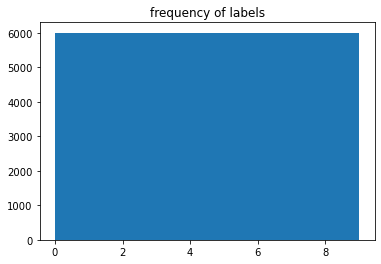

In [32]:
#samples distribution
plt.hist(y_train)
plt.title('frequency of labels')

Equal representation for all labels.